# Training CGNet in Antarctic Region

Purpose:
--------
The purpose of this notebook is to train CGnet for machine learning detection of atmospheric rivers and tropical cyclones.\
See ClimateNet repo here: https://github.com/andregraubner/ClimateNet

Authors/Contributors:
---------------------
* Teagan King
* John Truesdale
* Katie Dagon

## Import libraries

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/glade/work/tking/cgnet/ClimateNet")  # append path to ClimateNet repo
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events

from os import path

## Config file
Use `get_averages_and_standard_devs.ipynb` to calculate means/stds for given training dataset.

In [2]:
cd /glade/work/tking/cgnet/ML-extremes/trained_models/config_012024_TMQ/

/glade/work/tking/cgnet/ML-extremes/trained_models/config_012024_TMQ


In [3]:
config = Config('config.json')   # This works when you cd into directory, but not with a specified dirpath?
# TODO: make PR for https://github.com/andregraubner/ClimateNet/blob/main/climatenet/utils/utils.py

In [4]:
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_021523.json') # weighted mean, unweighted std; TMQ, U850, V850, PSL
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_040523.json') # unweighted mean and std; TMQ, U850, V850, PSL
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_092023_TMQ_V850.json') # unweighted mean and std, TMQ and V850 only
# config = Config('/glade/work/tking/cgnet/ML-extremes/trained_models/config_092023_TMQ/config.json') # unweighted mean and std, TMQ only

# config = Config('/glade/work/tking/cgnet/ML-extremes/trained_models/config_012024_TMQ_unweighted_mean_std.json') # unweighted mean and std, TMQ only


In [5]:
config.description

'The basic CGNet model. You can use this config to train your own model, or load it with our trained weights.'

In [6]:
config.train_batch_size

16

## Confirm GPU resources
Can request through JupyterHub launch page.\
Current resources request (2/15/23): 1 node, 4 cpu, 64GB mem, 2 V100 GPU\
4/5/23: Noticed that not all CPU/mem was needed, new request: 1 node, 2 cpu, 64GB mem, 2 V100 GPU

In [7]:
# conda install pytorch
# try running with 2 GPUs

In [8]:
# requires loading pytorch into environment
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
2


## Instantiate CGNet model given config file
This step needs GPU resources (as written)

In [9]:
%%time
cgnet = CGNet(config)

CPU times: user 896 ms, sys: 434 ms, total: 1.33 s
Wall time: 1.38 s


In [10]:
cgnet.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

## Set train, test data


## NEED TO CHANGE THIS FOR POLAR DATA!

In [11]:
# train_path = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new"
train_path = '/glade/work/tking/cgnet/QA_xml/all_antarctic_converted_masks/split_files'

train = ClimateDatasetLabeled(path.join(train_path+'/train_new_nolatlon/int/tmq_float/'), config)
test = ClimateDatasetLabeled(path.join(train_path+'/test'), config)

In [12]:
train.fields

{'tmq': {'mean': 21.593790761325735, 'std': 13.6215941728325}}

In [13]:
train.length

204

In [14]:
config.epochs

2

## Train model - TMQ, U850, V850, PSL

Memory use holding at ~14GB during training\
Each epoch takes ~1 min to run

In [15]:
cgnet.train(train)  # use ~20 epochs for non-test
# IOU mean should be around 0.75 after all epochs?
# weights and measures site to look at ML performance
# maybe playing with those parameters could improve model

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/13 [00:13<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 162.00 MiB (GPU 0; 31.74 GiB total capacity; 29.56 GiB already allocated; 149.56 MiB free; 1023.88 MiB cached)

In [19]:
# CUDA out of memory. Tried to allocate 162.00 MiB (GPU 0; 31.74 GiB total capacity; 29.56 GiB already allocated;
# 149.56 MiB free; 1023.88 MiB cached)

torch.cuda.__dict__


{'__name__': 'torch.cuda',
 '__doc__': '\nThis package adds support for CUDA tensor types, that implement the same\nfunction as CPU tensors, but they utilize GPUs for computation.\n\nIt is lazily initialized, so you can always import it, and use\n:func:`is_available()` to determine if your system supports CUDA.\n\n:ref:`cuda-semantics` has more details about working with CUDA.\n',
 '__package__': 'torch.cuda',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1477726cd828>,
 '__spec__': ModuleSpec(name='torch.cuda', loader=<_frozen_importlib_external.SourceFileLoader object at 0x1477726cd828>, origin='/glade/u/home/tking/anaconda3/envs/lbltorchplus/lib/python3.6/site-packages/torch/cuda/__init__.py', submodule_search_locations=['/glade/u/home/tking/anaconda3/envs/lbltorchplus/lib/python3.6/site-packages/torch/cuda']),
 '__path__': ['/glade/u/home/tking/anaconda3/envs/lbltorchplus/lib/python3.6/site-packages/torch/cuda'],
 '__file__': '/glade/u/home/tking/anaconda3/envs/l

In [ ]:
# DO this for each var in tsch to remove coordinates from all vars,
# rename x and y to lon/lat, rename ar_mask to LABELS, and remove lat/lon from file
foreach i (*nc)
ncatted -O -a coordinates,tmq,d,, $i
ncatted -O -a coordinates,ivt,d,, $i
ncatted -O -a coordinates,pr,d,, $i
ncatted -O -a coordinates,psl,d,, $i
ncrename -O -d x,lon -d y,lat -v x,lon -v y,lat $i # want to update utilities, but in meantime
ncrename -O -v ar_mask,LABELS $i # want to update utilities, but in meantime
ncks -C -x -v lat,lon $i $i:r.no_lat_lon.nc
echo $i
end

# also change the type that variables are
ncap2 -s "LABELS=int(LABELS)" $i tmq_int/$i
ncap2 -s "tmq=float(tmq)" 


int64 LABELS(lat, lon) ;
		LABELS:description = "0: Background, 1: Tropical Cyclone, 2: Athmospheric river"

2/15/23: Training is maxing out around 0.5977 IOU mean at last epoch\
4/5/23: With updated unweighted means, similar performance: 0.5996 IOU mean at last epoch

### TO DO: IOU/loss across epochs
Can I load in the values from the saved model?\
I think the source code needs to be modified to save out IOU/loss/CMs

In [35]:
# manual input from the above output for now...

# loss_4channel = [0.7929807901382446, 0.7859199643135071, 0.7832299470901489, 0.7821657657623291, 0.7858586311340332, 0.7822664380073547, 0.7820284962654114,
#                  0.780483603477478, 0.7820720672607422, 0.7849843502044678, 0.779705286026001, 0.7843253016471863, 0.7806265950202942, 0.7803990840911865,
#                  0.777285099029541, 0.7805625200271606, 0.7805108428001404, 0.7817416191101074, 0.7821648120880127, 0.7792255878448486]

In [43]:
epoch_range = np.arange(1, config.epochs+1)

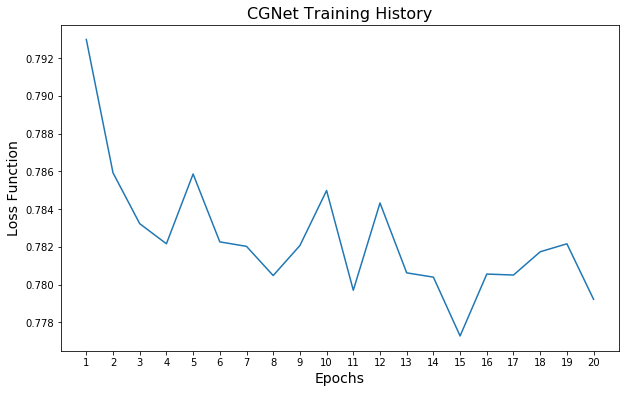

In [54]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, loss_4channel)
plt.ylabel('Loss Function', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History', fontsize=16)
#plt.savefig('../figures/toSCP/trained_cgnet_040523_loss_epochs.png', bbox_inches='tight')

In [56]:
# list of lists...
iou_4channel = [[0.82468027, 0.02955234, 0.20687647], [0.93040919, 0.24552735, 0.3499208 ], [0.93507817, 0.28566718, 0.37940629], [0.93728455, 0.31748401, 0.39551527],
                [0.93909495, 0.32430877, 0.40609776], [0.93881926, 0.32837483, 0.40964832], [0.94105241, 0.34036034, 0.42090875], [0.94089294, 0.34384409, 0.42345722],
                [0.94162572, 0.34306023, 0.42858825], [0.94344054, 0.34477355, 0.43985051], [0.94310998, 0.3519992, 0.43998411], [0.94407983, 0.34748465, 0.44698649],
                [0.94474442, 0.35277528, 0.45147414], [0.94506546, 0.35476714, 0.45588776], [0.94535843, 0.35674451, 0.45620809], [0.94492276, 0.35737601, 0.45649445],
                [0.94581481, 0.36649505, 0.46129547], [0.94701946, 0.36918933, 0.4702124 ], [0.94752383, 0.36973565, 0.47586048], [0.94800169, 0.37387946, 0.47704684]]

In [57]:
config.labels

['Background', 'Tropical Cyclone', 'Atmospheric River']

In [66]:
iou_4channel_mean = np.mean(iou_4channel, axis=1)
iou_4channel_mean

array([0.35370303, 0.50861911, 0.53338388, 0.55009461, 0.55650049,
       0.55894747, 0.5674405 , 0.56939808, 0.5710914 , 0.57602153,
       0.57836443, 0.57951699, 0.58299795, 0.58524012, 0.58610368,
       0.58626441, 0.59120178, 0.59547373, 0.59770665, 0.59964266])

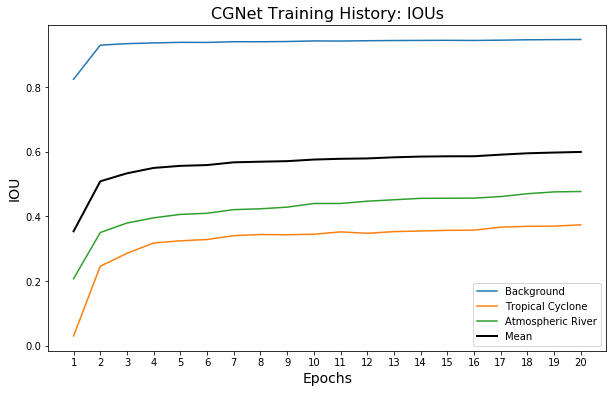

In [73]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, iou_4channel)
plt.plot(epoch_range, iou_4channel_mean, color='k', linewidth=2)
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean']);
#plt.savefig('../figures/toSCP/trained_cgnet_040523_iou_epochs.png', bbox_inches='tight')

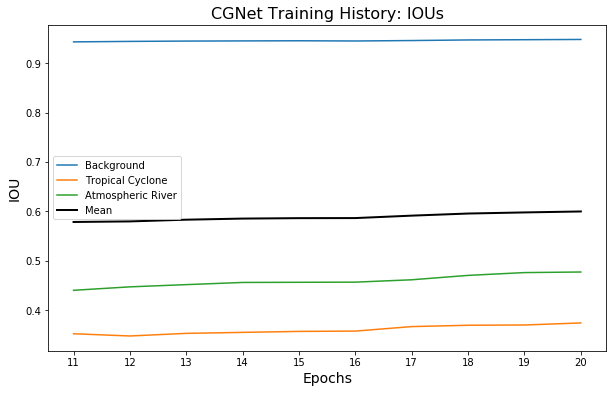

In [77]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range[10:], iou_4channel[10:])
plt.plot(epoch_range[10:], iou_4channel_mean[10:], color='k', linewidth=2)
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range[10:]);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean']);

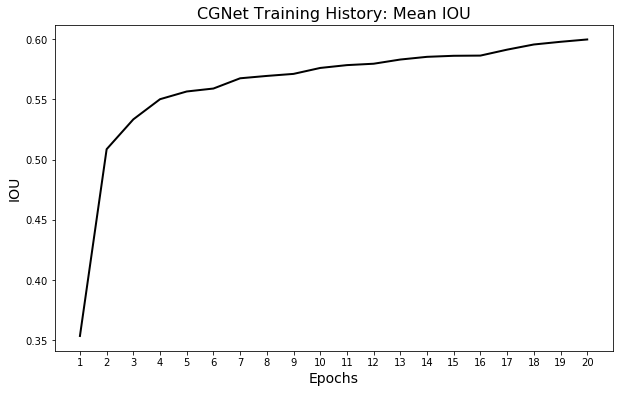

In [81]:
plt.figure(figsize=(10,6))
#plt.plot(epoch_range[10:], iou_4channel[10:])
plt.plot(epoch_range, iou_4channel_mean, color='k', linewidth=2)
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: Mean IOU', fontsize=16);
#plt.savefig('../figures/toSCP/trained_cgnet_040523_mean-iou_epochs.png', bbox_inches='tight')

In [86]:
# testing results from below
iou_4channel_test = [0.9450045, 0.35225587, 0.39795872]

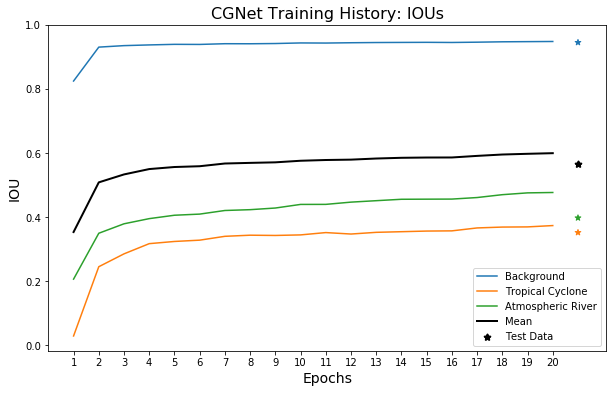

In [104]:
plt.figure(figsize=(10,6))
plt.plot(epoch_range, iou_4channel)
plt.plot(epoch_range, iou_4channel_mean, color='k', linewidth=2)
plt.scatter([21], np.mean(iou_4channel_test), marker='*', color='k', linewidth=2)
plt.scatter([21,21,21], iou_4channel_test, marker='*', color=['C0','C1','C2'])
plt.ylabel('IOU', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.xticks(epoch_range);
plt.title('CGNet Training History: IOUs', fontsize=16)
plt.legend(config.labels+['Mean', 'Test Data']);
#plt.savefig('../figures/toSCP/trained_cgnet_040523_iou_epochs_testdata.png', bbox_inches='tight')

## Train model - TMQ, V850

Memory use holding at ~12GB during training\
Each epoch takes ~1 min to run

In [11]:
%%time
cgnet.train(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.67465901e+08 3.57088010e+07 2.73459970e+07]
 [1.03063000e+06 3.48909000e+05 2.46808000e+05]
 [8.90030200e+06 1.60290200e+06 9.47467800e+06]]
IOUs:  [0.78562085 0.00896062 0.19917051] , mean:  0.3312506607117836
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16022333e+08 1.03130400e+06 1.34670620e+07]
 [1.07174800e+06 4.20121000e+05 1.34478000e+05]
 [8.50047600e+06 1.13408000e+05 1.13639980e+07]]
IOUs:  [0.92922349 0.15161027 0.33842149] , mean:  0.4730850828498043
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16828427e+08 9.02941000e+05 1.27893310e+07]
 [8.93811000e+05 6.19459000e+05 1.13077000e+05]
 [7.59652800e+06 1.14034000e+05 1.22673200e+07]]
IOUs:  [0.9345667  0.23434867 0.37309038] , mean:  0.5140019183494055
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17239392e+08 8.71752000e+05 1.24095550e+07]
 [8.19333000e+05 6.97907000e+05 1.09107000e+05]
 [7.17216300e+06 1.03660000e+05 1.27020590e+07]]
IOUs:  [0.93715794 0.26824429 0.39087415] , mean:  0.5320921277325162
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17103897e+08 9.32084000e+05 1.24847180e+07]
 [7.37931000e+05 7.81798000e+05 1.06618000e+05]
 [6.95439700e+06 9.12360000e+04 1.29322490e+07]]
IOUs:  [0.93758629 0.29505519 0.39706968] , mean:  0.5432370534226606
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17638183e+08 9.13228000e+05 1.19692880e+07]
 [6.95001000e+05 8.27213000e+05 1.04133000e+05]
 [6.81995700e+06 8.04160000e+04 1.30775090e+07]]
IOUs:  [0.93965881 0.31573124 0.40801801] , mean:  0.5544693535965578
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17645556e+08 9.58735000e+05 1.19164080e+07]
 [6.69070000e+05 8.64044000e+05 9.32330000e+04]
 [6.76188600e+06 8.99450000e+04 1.31260510e+07]]
IOUs:  [0.93991419 0.32300384 0.41034909] , mean:  0.5577557079336068
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17617959e+08 1.06870700e+06 1.18340330e+07]
 [6.46515000e+05 8.88955000e+05 9.08770000e+04]
 [6.43352000e+06 8.81220000e+04 1.34562400e+07]]
IOUs:  [0.94080944 0.31940308 0.42178879] , mean:  0.5606671060544012
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17591735e+08 9.50123000e+05 1.19788410e+07]
 [6.44885000e+05 8.81981000e+05 9.94810000e+04]
 [6.28976700e+06 7.67120000e+04 1.36114030e+07]]
IOUs:  [0.94113705 0.33242386 0.42461057] , mean:  0.5660571606733165
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17664698e+08 9.94052000e+05 1.18619490e+07]
 [6.26253000e+05 9.10928000e+05 8.91660000e+04]
 [6.24123000e+06 8.49410000e+04 1.36517110e+07]]
IOUs:  [0.94154068 0.33671479 0.42756467] , mean:  0.5686067135812413
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17938264e+08 9.94661000e+05 1.15877740e+07]
 [6.16863000e+05 9.17957000e+05 9.15270000e+04]
 [6.08511400e+06 7.84680000e+04 1.38143000e+07]]
IOUs:  [0.94281401 0.34005007 0.43637174] , mean:  0.5730786065887492
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18184245e+08 1.00032200e+06 1.13361320e+07]
 [5.97795000e+05 9.41979000e+05 8.65730000e+04]
 [5.92710900e+06 8.13370000e+04 1.39694360e+07]]
IOUs:  [0.94403915 0.34784967 0.44487818] , mean:  0.5789223346143332
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18011244e+08 1.01001200e+06 1.14994430e+07]
 [5.89306000e+05 9.43445000e+05 9.35960000e+04]
 [5.81776400e+06 7.47400000e+04 1.40853780e+07]]
IOUs:  [0.94385584 0.34799356 0.44615037] , mean:  0.579333258238884
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18033228e+08 9.89248000e+05 1.14982230e+07]
 [5.98231000e+05 9.38768000e+05 8.93480000e+04]
 [5.84485700e+06 7.91840000e+04 1.40538410e+07]]
IOUs:  [0.9438202  0.34836549 0.44522855] , mean:  0.5791380797120701
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18469246e+08 1.01845500e+06 1.10329980e+07]
 [6.07922000e+05 9.33354000e+05 8.50710000e+04]
 [5.77961400e+06 7.77110000e+04 1.41205570e+07]]
IOUs:  [0.94527    0.34282812 0.45409632] , mean:  0.580731477967095
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18273513e+08 1.04619500e+06 1.12009910e+07]
 [5.67483000e+05 9.71889000e+05 8.69750000e+04]
 [5.54396000e+06 7.99110000e+04 1.43540110e+07]]
IOUs:  [0.94546383 0.35309922 0.45909553] , mean:  0.5858861905516117
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18590595e+08 1.02865400e+06 1.09014500e+07]
 [5.76493000e+05 9.65659000e+05 8.41950000e+04]
 [5.52842700e+06 8.07270000e+04 1.43687280e+07]]
IOUs:  [0.94642409 0.35298063 0.46405334] , mean:  0.5878193527419585
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18595291e+08 1.05134000e+06 1.08740680e+07]
 [5.64487000e+05 9.78873000e+05 8.29870000e+04]
 [5.42933800e+06 7.90550000e+04 1.44694890e+07]]
IOUs:  [0.94675049 0.35508328 0.4677394 ] , mean:  0.5898577262558553
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18708072e+08 1.00919900e+06 1.08034280e+07]
 [5.63307000e+05 9.80795000e+05 8.22450000e+04]
 [5.39482500e+06 7.93020000e+04 1.45037550e+07]]
IOUs:  [0.9471861  0.36127069 0.46993145] , mean:  0.5927960774207156
Epoch 20:


Loss: 0.775212824344635: 100%|██████████| 25/25 [00:58<00:00,  2.34s/it] 

Epoch stats:
[[3.18759946e+08 1.02135900e+06 1.07393940e+07]
 [5.59122000e+05 9.88235000e+05 7.89900000e+04]
 [5.16193600e+06 7.68240000e+04 1.47391220e+07]]
IOUs:  [0.94800821 0.36271761 0.47860094] , mean:  0.5964422534915425
CPU times: user 10min 48s, sys: 6min 10s, total: 16min 58s
Wall time: 19min 54s


9/20/23: Training is maxing out at 0.5964 IOU mean at last epoch

## Train model - TMQ

Memory use holding at ~13GB during training\
Each epoch takes ~1 min to run

In [34]:
%%time
cgnet.train(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.84238956e+08 1.84050650e+07 2.78766780e+07]
 [1.13390200e+06 3.04555000e+05 1.87890000e+05]
 [8.54513000e+06 9.36724000e+05 1.04960280e+07]]
IOUs:  [0.83550612 0.01452466 0.21847404] , mean:  0.3561682703590215
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18264835e+08 9.21300000e+03 1.22466510e+07]
 [1.51578700e+06 6.59000000e+02 1.09901000e+05]
 [8.70045200e+06 3.20000000e+01 1.12773980e+07]]
IOUs:  [9.34048527e-01 4.02912218e-04 3.48773632e-01] , mean:  0.42774169052947997
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18341276e+08 0.00000000e+00 1.21794230e+07]
 [1.51056500e+06 4.60000000e+01 1.15736000e+05]
 [7.83816600e+06 0.00000000e+00 1.21397160e+07]]
IOUs:  [9.36657575e-01 2.82842468e-05 3.76156557e-01] , mean:  0.4376141387704749
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18172222e+08 0.00000000e+00 1.23484770e+07]
 [1.50147300e+06 1.00000000e+00 1.24873000e+05]
 [7.31193400e+06 0.00000000e+00 1.26659480e+07]]
IOUs:  [9.37637026e-01 6.14874931e-07 3.90307154e-01] , mean:  0.4426482649288845
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18501659e+08 0.00000000e+00 1.20190400e+07]
 [1.50758200e+06 0.00000000e+00 1.18765000e+05]
 [7.13927700e+06 0.00000000e+00 1.28386050e+07]]
IOUs:  [0.93906876 0.         0.39976118] , mean:  0.44627664823791297
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18495846e+08 0.00000000e+00 1.20248530e+07]
 [1.50062500e+06 0.00000000e+00 1.25722000e+05]
 [6.94342000e+06 0.00000000e+00 1.30344620e+07]]
IOUs:  [0.93961349 0.         0.40569835] , mean:  0.4484372799779974
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18512677e+08 0.00000000e+00 1.20080220e+07]
 [1.50574400e+06 0.00000000e+00 1.20603000e+05]
 [6.68270000e+06 0.00000000e+00 1.32951820e+07]]
IOUs:  [0.94037224 0.         0.41409618] , mean:  0.45148947581739085
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18696912e+08 0.00000000e+00 1.18237870e+07]
 [1.49548000e+06 0.00000000e+00 1.30867000e+05]
 [6.54836000e+06 0.00000000e+00 1.34295220e+07]]
IOUs:  [0.94131805 0.         0.42055921] , mean:  0.45395908582630345
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.1871988e+08 0.0000000e+00 1.1800819e+07]
 [1.5046830e+06 0.0000000e+00 1.2166400e+05]
 [6.5041360e+06 0.0000000e+00 1.3473746e+07]]
IOUs:  [0.94148328 0.         0.42236965] , mean:  0.4546176423657821
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18754025e+08 0.00000000e+00 1.17666740e+07]
 [1.50638400e+06 0.00000000e+00 1.19963000e+05]
 [6.39829800e+06 0.00000000e+00 1.35795840e+07]]
IOUs:  [0.94187387 0.         0.42616629] , mean:  0.4560133899553898
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19092355e+08 0.00000000e+00 1.14283440e+07]
 [1.50480600e+06 0.00000000e+00 1.21541000e+05]
 [6.25503800e+06 0.00000000e+00 1.37228440e+07]]
IOUs:  [0.94327729 0.         0.43526216] , mean:  0.4595131514989932
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18760685e+08 0.00000000e+00 1.17600140e+07]
 [1.50223600e+06 0.00000000e+00 1.24111000e+05]
 [6.03913100e+06 0.00000000e+00 1.39387510e+07]]
IOUs:  [0.94290581 0.         0.43747247] , mean:  0.46012609320876047
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19542161e+08 0.00000000e+00 1.09785380e+07]
 [1.49686900e+06 0.00000000e+00 1.29478000e+05]
 [6.06905200e+06 0.00000000e+00 1.39088300e+07]]
IOUs:  [0.94514879 0.         0.44743214] , mean:  0.46419364594567664
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19171032e+08 0.00000000e+00 1.13496670e+07]
 [1.49944300e+06 0.00000000e+00 1.26904000e+05]
 [5.81475700e+06 0.00000000e+00 1.41631250e+07]]
IOUs:  [0.94475447 0.         0.45027408] , mean:  0.4650095189034851
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18931613e+08 0.00000000e+00 1.15890860e+07]
 [1.49573800e+06 0.00000000e+00 1.30609000e+05]
 [5.73924800e+06 0.00000000e+00 1.42386340e+07]]
IOUs:  [0.94426719 0.         0.4492026 ] , mean:  0.4644899313778658
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19497912e+08 0.00000000e+00 1.10227870e+07]
 [1.50557200e+06 0.00000000e+00 1.20775000e+05]
 [5.65231200e+06 0.00000000e+00 1.43255700e+07]]
IOUs:  [0.94615983 0.         0.46031187] , mean:  0.4688239003895394
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19636151e+08 0.00000000e+00 1.08845480e+07]
 [1.51050400e+06 0.00000000e+00 1.15843000e+05]
 [5.46656400e+06 0.00000000e+00 1.45113180e+07]]
IOUs:  [0.94707634 0.         0.46843534] , mean:  0.47183722938879064
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19583461e+08 0.00000000e+00 1.09372380e+07]
 [1.49381900e+06 0.00000000e+00 1.32528000e+05]
 [5.28747200e+06 0.00000000e+00 1.46904100e+07]]
IOUs:  [0.94746984 0.         0.47315694] , mean:  0.4735422572121362
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.19838486e+08 0.00000000e+00 1.06822130e+07]
 [1.50151900e+06 1.40000000e+01 1.24814000e+05]
 [5.37105700e+06 0.00000000e+00 1.46068250e+07]]
IOUs:  [9.47969357e-01 8.60824904e-06 4.74480045e-01] , mean:  0.47415267004189765
Epoch 20:


Loss: 0.7837892174720764: 100%|██████████| 25/25 [01:03<00:00,  2.53s/it]

Epoch stats:
[[3.19462395e+08 6.00000000e+00 1.10582980e+07]
 [1.48727600e+06 0.00000000e+00 1.39071000e+05]
 [5.10564100e+06 0.00000000e+00 1.48722410e+07]]
IOUs:  [0.94764014 0.         0.47705281] , mean:  0.47489764974583665
CPU times: user 10min 16s, sys: 5min 36s, total: 15min 53s
Wall time: 18min 50s


9/20/23: Training is maxing out at 0.4749 IOU mean at last epoch

### TO DO: output masks during training so we can visually check match between training data and what model predicts?
Instead of simply relying on IOU. Also check the loss function here.\
Below, have found a way to save out testing data masks to compare predictions vs. labels on the test data.

### TO DO: increase # epochs? play with batch size, other hyperparameters; random seed for spread
See CGnet papers (Kapp-Schwoerer et al. and Lacombe et al.)

## Evaluate model on test data - TMQ, U850, V850, PSL

In [15]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541},
 'PSL': {'mean': 100814.078125, 'std': 1461.225830078125}}

In [16]:
test.length

61

In [16]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

Evaluation stats:
[[4.9207437e+07 1.6860800e+05 1.2782570e+06]
 [1.2489300e+05 1.6929100e+05 2.4100000e+03]
 [1.2919190e+06 1.5389000e+04 1.7106920e+06]]
IOUs:  [0.9450045  0.35225587 0.39795872] , mean:  0.5650730277914003
CPU times: user 1.64 s, sys: 1.65 s, total: 3.29 s
Wall time: 9.97 s


2/15/23: Testing data is at 0.55 IOU mean\
4/5/23: Testing data is at 0.56 IOU mean

## Evaluate model on test data - TMQ, V850

In [12]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541}}

In [15]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:09<00:00,  2.31s/it]

Evaluation stats:
[[4.8270906e+07 1.7247800e+05 2.2109180e+06]
 [1.2835800e+05 1.6712400e+05 1.1120000e+03]
 [9.6592800e+05 1.7096000e+04 2.0349760e+06]]
IOUs:  [0.93279658 0.34375771 0.38909452] , mean:  0.5552162709391156
CPU times: user 1.42 s, sys: 1.16 s, total: 2.59 s
Wall time: 9.23 s


9/20/23: Testing data is at 0.55 IOU mean\
Similar (perhaps slightly degraded) performance to 4 input fields version

## Evaluate model on test data - TMQ

In [82]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879}}

In [83]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:15<00:00,  3.77s/it]

Evaluation stats:
[[4.9289379e+07 0.0000000e+00 1.3649230e+06]
 [2.9495600e+05 0.0000000e+00 1.6380000e+03]
 [1.3877350e+06 0.0000000e+00 1.6302650e+06]]
IOUs:  [0.94176941 0.         0.37181944] , mean:  0.4378629486893792
CPU times: user 1.24 s, sys: 985 ms, total: 2.22 s
Wall time: 15.1 s


9/20/23: Testing data is at 0.43 IOU mean\
Unable to detect TCs with just TMQ but AR performance is similar (slightly degraded as you remove input fields)

## Save out model

In [84]:
# makes a folder by the name specified, puts the trained model and config file in there
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.021523') # TMQ, U850, V850, PSL; weighted means and unweighted std in config file
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523') # TMQ, U850, V850, PSL; unweighted means/std in config file
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.092023_TMQ_V850') # TMQ, V850; unweighted means/std in config file
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.092023_TMQ') # TMQ; unweighted means/std in config file

cgnet.save_model('/glade/work/tking/cgnet/ML-extremes/trained_models/trained_cgnet.012024_TMQ_unweighted_mean_std')

## Load in previously trained model

In [13]:
#cgnet.load_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.021523') # TMQ, U850, V850, PSL; weighted means and unweighted std in config file
#cgnet.load_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523') # TMQ, U850, V850, PSL; unweighted means/std in config file

cgnet.load_model('/glade/work/tking/cgnet/ML-extremes/trained_models/trained_cgnet.012024_TMQ_unweighted_mean_std')

## Predict on test data
Need to reload test data as `ClimateDataset` in order to use `.predict`

In [19]:
test_path = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new/test"
test_data = ClimateDataset(test_path, config)

In [20]:
%%time
test_masks = cgnet.predict(test_data)

100%|██████████| 4/4 [00:21<00:00,  5.25s/it]

CPU times: user 2.74 s, sys: 2.05 s, total: 4.79 s
Wall time: 21.2 s


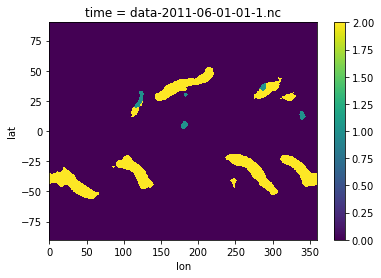

In [32]:
test_masks.isel(time=0).plot();

## Save out test data masks

In [35]:
%%time
test_masks.name = 'masks'
test_masks.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/evaluate/test_masks.040523.nc") # trained_cgnet.040523 applied to test data to evaluate predictions vs. labels

CPU times: user 2.35 ms, sys: 142 ms, total: 144 ms
Wall time: 168 ms


## Set inference data

In [38]:
year=2000
#inference_path = "/glade/campaign/cgd/amp/jet/ClimateNet/Climate_data_"+str(year)
#inference_path = "/glade/scratch/tking/cgnet/historical_2000_2005/split_files"
inference_path = "/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/"+str(year)

inference = ClimateDataset(inference_path, config)  # could test different config with std/means for inference data

In [39]:
inference.fields

{'TMQ': {'mean': 24.927238169017997, 'std': 15.817276954650879},
 'U850': {'mean': 1.0356735863118816, 'std': 8.29762077331543},
 'V850': {'mean': 0.20847854977498861, 'std': 6.231630802154541},
 'PSL': {'mean': 101095.03520124489, 'std': 1461.225830078125}}

In [40]:
inference.length

17520

## Inference mode
This is now done more systematically in `cgnet_run_pre_trained_model.ipynb`.

In [35]:
%%time
class_masks = cgnet.predict(inference) # masks with 1==TC, 2==AR

100%|██████████| 183/183 [06:38<00:00,  2.18s/it]


CPU times: user 2min 17s, sys: 1min 8s, total: 3min 26s
Wall time: 6min 46s


## Save out masks

In [36]:
%%time
class_masks.to_netcdf("/glade/scratch/kdagon/cgnet/class_masks."+str(year)+".nc")

CPU times: user 55.9 ms, sys: 4.16 s, total: 4.22 s
Wall time: 7.53 s


## Track events
Create masks with event IDs

Note: memory spikes here - resource intensive!

In [ ]:
%%time
event_masks = track_events(class_masks)

In [ ]:
%%time
event_masks.to_netcdf("/glade/scratch/kdagon/cgnet/event_masks."+str(year)+".test.nc")

## Analyze events
Produce some visualizations

In [ ]:
analyze_events(event_masks, class_masks, "/glade/scratch/kdagon/cgnet/")

In [ ]:
visualize_events(event_masks, inference, "/glade/scratch/kdagon/cgnet/")   

## Weights and Biases
https://docs.wandb.ai/quickstart \
Potential tool for hyperparameter optimization\
Still figuring out how this works...

In [42]:
import wandb

In [44]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: Appending key for api.wandb.ai to your netrc file: /glade/u/home/kdagon/.netrc


True

In [46]:
wandb.init(project="climatenet-test", entity="katie-dagon")

Ignoring settings passed to wandb.setup() which has already been configured.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: Appending key for api.wandb.ai to your netrc file: /glade/u/home/kdagon/.netrc
wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20230215_172859-2auiboc1
wandb: Syncing run decent-river-1


In [47]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 20,
  "batch_size": 16
}

In [49]:
wandb.log({"loss": loss})

NameError: name 'loss' is not defined